In [19]:
from SAM import SAM
import numpy as np
import pandas as pd
import sklearn.metrics as met
import utilities as ut
import utilities_full as ut2
from sklearn.preprocessing import Normalizer
import pickle

def DARMANIS(**kwargs):
    sam = SAM()
    sam.load_data('darmanis/darmanis_data.csv', **kwargs)
    sam.load_obs_annotations('darmanis/darmanis_ann.csv')
    sam.preprocess_data()
    return sam

def WANG(**kwargs):
    sam = SAM()
    sam.load_data('final_datasets/GSE83139/wang_data_sparse.p', **kwargs)
    sam.preprocess_data(filter_genes=False,min_expression=1)
    A = pd.read_csv('final_datasets/GSE83139/wang_ann.csv',header=None,index_col=0)    
    A.index = A.index.astype("<U100")
    sam.adata.obs['ann'] = A
    sam.adata.var_names_make_unique()
    return sam

def human1(**kwargs):
    sam = SAM()
    sam.load_data('final_datasets/GSE84133_1/human1_sparse.p')
    sam.preprocess_data()
    sam.load_obs_annotations('final_datasets/GSE84133_1/human1_ann.csv')
    return sam


def human2(**kwargs):
    sam = SAM()
    sam.load_data('final_datasets/GSE84133_2/human2_sparse.p')
    sam.preprocess_data()
    sam.load_obs_annotations('final_datasets/GSE84133_2/human2_ann.csv')
    return sam

def human3(**kwargs):
    sam = SAM()
    sam.load_data('final_datasets/GSE84133_3/human3_sparse.p')
    sam.preprocess_data()
    sam.load_obs_annotations('final_datasets/GSE84133_3/human3_ann.csv')
    return sam
def human4(**kwargs):
    sam = SAM()
    sam.load_data('final_datasets/GSE84133_4/human4_sparse.p')
    sam.preprocess_data()
    sam.load_obs_annotations('final_datasets/GSE84133_4/human4_ann.csv')
    return sam


def KOH(**kwargs):
    sam = SAM()
    sam.load_data('final_datasets/SRP073808/SRP073808_data.csv',
                            **kwargs)
    sam.load_obs_annotations('final_datasets/SRP073808/SRP073808_ann.csv')
    sam.preprocess_data()
    return sam


def SEGER(**kwargs):
    sam=SAM()
    sam.load_data('final_datasets/seger/seger_sparse.p')
    sam.load_obs_annotations('final_datasets/seger/seger_ann.csv')
    sam.preprocess_data()
    return sam


def MURARO(**kwargs):
    sam=SAM()
    sam.load_data('final_datasets/muraro/muraro_sparse.p')
    sam.load_obs_annotations('final_datasets/muraro/muraro_ann.csv')
    sam.preprocess_data()
    return sam
def ari(x, y):
    return met.adjusted_rand_score(x, y)

def SEURAT(adata,npcs,ngenes):
    pca,_,_,_ = ut2.do_SEURAT4(adata.copy(),npcs=npcs,NN=ngenes)
    cl = hdbknn(pca)
    return pca,cl

def hdbknn(X):
    import hdbscan
    k=20

    hdb = hdbscan.HDBSCAN(metric='euclidean')

    cl = hdb.fit_predict(Normalizer().fit_transform(X))

    idx0 = np.where(cl != -1)[0]
    idx1 = np.where(cl == -1)[0]
    if idx1.size > 0 and idx0.size > 0:
        xcmap = ut.generate_euclidean_map(X[idx0, :], X[idx1, :])
        knn = np.argsort(xcmap.T, axis=1)[:, :k]
        nnm = np.zeros(xcmap.shape).T
        nnm[np.tile(np.arange(knn.shape[0])[:, None],
                    (1, knn.shape[1])).flatten(),
            knn.flatten()] = 1
        nnmc = np.zeros((nnm.shape[0], cl.max() + 1))
        for i in range(cl.max() + 1):
            nnmc[:, i] = nnm[:, cl[idx0] == i].sum(1)

        cl[idx1] = np.argmax(nnmc, axis=1)

    return cl

In [10]:
preproc = ['Normalizer','Normalizer']+['StandardScaler',]*4+['Normalizer',]*3
funcs = [DARMANIS(),WANG(),human1(),human2(),human3(),human4(),KOH(),SEGER(),MURARO()]
names = ['DARMANIS','WANG','human1','human2','human3','human4','KOH','SEGER','MURARO']

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Converting sparse matrix to csr format...
Converting sparse matrix to csr format...


In [13]:
(C0,C1,C2,C3) = pickle.load(open('paper_scripts/cluster_assignments_sc3_sim_seur_fixed.p','rb'))

In [18]:
ngenes = [500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,-1]
npcs = [6,10,15,20,25,30,35,40,45,50]
RECORDd = pickle.load(open('paper_scripts/seurat_param_sweep_bigger_fixed.p','rb'))
nge=[]
npc=[]
for i in names:
    ind = np.where(RECORDd[i]>= RECORDd[i].max())
    n1,n2 = ngenes[ind[0][0]],npcs[ind[1][0]]
    nge.append(n1)
    npc.append(n2)
npc[1]=6
nge[1]=3000

In [149]:
ARIsamL,ARIseurL,ARIseurR,ARIseurO = pickle.load(open('paper_scripts/8_23_2019_all_permute2.p','rb'))
K = np.zeros((5,len(C0)))
A = np.zeros((5,len(C0)))
for i in range(len(C0)):
    adata = funcs[i].adata_raw.copy()
    if i==1:
        adata.X[adata.X<1]=0
        adata.X.eliminate_zeros()
    cl = SEURAT(adata,npc[i],nge[i])[1]
        
    K[0,i] = np.unique(C0[i]).size - np.unique(funcs[i].adata.obs.iloc[:,0]).size
    K[3,i] = np.unique(C1[i]).size - np.unique(funcs[i].adata.obs.iloc[:,0]).size
    K[4,i] = np.unique(C2[i]).size - np.unique(funcs[i].adata.obs.iloc[:,0]).size
    K[1,i] = np.unique(C3[i]).size - np.unique(funcs[i].adata.obs.iloc[:,0]).size
    K[2,i] = np.unique(cl).size - np.unique(funcs[i].adata.obs.iloc[:,0]).size
    
    A[0,i] = ARIsamL[i][1].mean(0)[0]#ari(C0[i],funcs[i].adata.obs.iloc[:,0])
    A[3,i] = ari(C1[i],funcs[i].adata.obs.iloc[:,0])
    A[4,i] = ari(C2[i],funcs[i].adata.obs.iloc[:,0])
    A[1,i] = ARIseurL[i][1].mean(0)[0]#ari(C3[i],funcs[i].adata.obs.iloc[:,0])
    A[2,i] = ARIseurO[i][1].mean(0)[0]#ari(cl,funcs[i].adata.obs.iloc[:,0])

2000
1000
4000
4500
2500
5000
6000
3500
2000


In [150]:
KARI = pd.DataFrame(data = K.T, index = ['Darmanis','Wang','Baron1','Baron2','Baron3','Baron4','Koh','Segerstolpe','Muraro'],columns = ['SAM','Seurat','Seurat Opt','SC3','SIMLR'])
ARI = pd.DataFrame(data = A.T, index = ['Darmanis','Wang','Baron1','Baron2','Baron3','Baron4','Koh','Segerstolpe','Muraro'],columns = ['SAM','Seurat','Seurat Opt','SC3','SIMLR'])

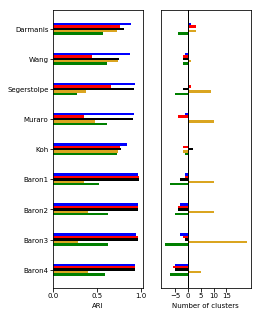

In [168]:
import matplotlib.pyplot as plt
def mm2inch(*tupl):
    inch = 25.4
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
def subcategorybar(X,vals,L, colors,ax, width=0.4):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        ax.barh(_X - width/2. + i/float(n)*width, vals[i], linewidth=0.0,
                height=width/float(n), align="edge", color=colors[i], label = L[i])   
    ax.set_yticks(_X)
    ax.set_yticklabels(X)
    
KARI = KARI.T[['Darmanis','Wang','Segerstolpe','Muraro','Koh','Baron1','Baron2','Baron3','Baron4']].T
KARI = KARI.iloc[:,::-1]
KARI = KARI.iloc[::-1,:]

ARI = ARI.T[['Darmanis','Wang','Segerstolpe','Muraro','Koh','Baron1','Baron2','Baron3','Baron4']].T
#ARI = ARI.iloc[:,::-1]
#ARI = ARI.iloc[::-1,:]

fig,axs = plt.subplots(nrows=1,ncols=2)

fig.set_size_inches(mm2inch(90,55*2+20))

for j in range(len(axs)):
    f=axs[j].get_xticklabels()
    f2=axs[j].get_yticklabels()
    for i in f: i.set_fontsize(7)
    for i in f2: i.set_fontsize(7)

X = ['Darmanis','Wang','Segerstolpe','Muraro','Koh','Baron1','Baron2','Baron3','Baron4']#['A','B','C']
val = ARI.T[['Darmanis','Wang','Segerstolpe','Muraro','Koh','Baron1','Baron2','Baron3','Baron4']].T.values
val=val[::-1,:]
X=X[::-1]
Y = []
for i in range(val.shape[1]):
    Y.append(list(val[:,i]))
Y=Y[::-1]

colors = ['green','goldenrod','black','red','blue']
L=['SAM','Seurat','Seruat Opt','SC3','SIMLR']
subcategorybar(X, Y, L, colors, axs[0])
axs[0].legend()

axs[0].get_legend().remove()
box = axs[0].get_position()
#axs[0].set_position([box.x0,box.y0,box.width*0.8,box.height])
axs[0].set_xlabel('ARI',fontsize=7)
axs[0].set_xticks([0,0.5,1])

X = ['Darmanis','Wang','Segerstolpe','Muraro','Koh','Baron1','Baron2','Baron3','Baron4']#['A','B','C']
val = KARI.T[['Darmanis','Wang','Segerstolpe','Muraro','Koh','Baron1','Baron2','Baron3','Baron4']].T.values
val=val[::-1,:]
X=X[::-1]
Y = []
for i in range(val.shape[1]):
    Y.append(list(val[:,i]))
Y=Y[::-1]

colors = ['green','goldenrod','black','red','blue']
L=['SAM','Seurat','Seruat Opt','SC3','SIMLR']
subcategorybar(X, Y, L, colors, axs[1])
axs[1].legend()

colors = ['green','goldenrod','black','red','blue']
z=0
for i in range(len(colors)):
    c = colors[i]
    for j in range(KARI.shape[0]):
        #barlist.get_children()[z].set_color(c)
        z+=1     
axs[1].set_yticks([])        
axs[1].set_yticklabels([]) 
axs[1].set_xticks([-5,0,5,10,15])   
axs[1].get_legend().remove()
axs[1].axvline(0,linestyle='-',color='k',linewidth=1)


box = axs[1].get_position()
#axs[1].set_position([box.x0-0.1,box.y0,box.width*1,box.height])

han,lab = axs[1].get_legend_handles_labels()
lab = lab[::-1]
han = han[::-1]

axs[1].set_xlabel('Number of clusters',fontsize=7)
axs[1].axis('tight')
axs[0].tick_params(pad=1)
axs[1].tick_params(pad=1)
plt.savefig('/media/storage/dbox/Dropbox/paper_scripts/barplot.pdf')